<div class="alert alert-block alert-info">
<b>Notice:</b> This companion notebook showcases the main features implemented in this repository and unravels code from other python files.
   
It illustrates the <a href=#generation>generation</a> of controlled datasets of synthetic networks relying on generator functions, as well as its analysis through a Graph Representer method.

Based on a module capable of embedding graphs within a vector space, the experimental pipeline is:
<li> <a href=#net_emb>Embedding</a> the networks
<li> Performing <a href=#classification>classification</a> on the synthetic dataset based on the produced vector representations
<li> <a href=#visualise>Visualise</a> the distribution of the representations of the different families of networks generated in 2 dimensions
<li> Analysing the ability of the model to produce <a href=#space_seg>semantically coherent representations</a> in the induced space

    
</div>

# Space Segregation Analysis

In [1]:
from space_seg.space_seg_classes import *

%load_ext autoreload
%autoreload 2

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# plotting parameters

plt.rcParams.update({'font.size': 14})
sns.set(font_scale=1.2, style='white')

# Custom Synthetic Dataset Generation <a class="anchor" id="generation"></a>

The generation of a controlled dataset relies on pre-determined generators. These tools are used to generate networks stemming from semantically different generative processes.

The *generators* and generative process are handled by the `synthetic` pipeline.

## ✍️ Initialisation <a class="anchor" id="init"></a>

In [3]:
# generated families, network names, path to the generator file and number of graphs wished

gen_fams_dict = {
    # Canonical
    "PA": {
        "k": {
            "generator_path": GEN_PATH+"k.gen",
            "number_generated":N_GRAPHS
        }
    },
    "ER": {
        "c1": {
            "generator_path": GEN_PATH+"c1.gen",
            "number_generated":N_GRAPHS
        },
    },
    "ID": {
        "id": {
            "generator_path": GEN_PATH+"id.gen",
            "number_generated":N_GRAPHS
        }
    },
    "d": {
        "d": {
            "generator_path": GEN_PATH+"d.gen",
            "number_generated": N_GRAPHS
        }
    },

}

In [4]:
# generating the grid : number of nodes and edges of the synthetic graphs

generated_nodes = np.arange(100, 1100, 100)[:6]
generated_densities = np.linspace(0.001, 0.2, 10)

MIN_AV_DEG = 5
MAX_AV_DEG = 200

ve_values = [
    (v, e)  
    for v in generated_nodes
    for e in numbers_of_edges(v
                              , densities = generated_densities
                             )
    if (
        coherent_max_edges(nodes=v, edges=e)
        and av_deg(v, e) >= MIN_AV_DEG
        and av_deg(v, e) <= MAX_AV_DEG
    )
]

In [5]:
for n in generated_nodes:
    edges_for_n = [ne[1] for ne in ve_values if ne[0]==n]
    print("Nodes: {} ( {} distinct number of edges )".format(n, len(edges_for_n)))
    for e in edges_for_n:
        print("       Edges : {} (<k> = {:.3g})".format(e, av_deg(n,e)))

Nodes: 100 ( 7 distinct number of edges )
       Edges : 333 (<k> = 6.66)
       Edges : 443 (<k> = 8.86)
       Edges : 552 (<k> = 11)
       Edges : 662 (<k> = 13.2)
       Edges : 771 (<k> = 15.4)
       Edges : 881 (<k> = 17.6)
       Edges : 990 (<k> = 19.8)
Nodes: 200 ( 8 distinct number of edges )
       Edges : 900 (<k> = 9)
       Edges : 1340 (<k> = 13.4)
       Edges : 1780 (<k> = 17.8)
       Edges : 2220 (<k> = 22.2)
       Edges : 2660 (<k> = 26.6)
       Edges : 3100 (<k> = 31)
       Edges : 3540 (<k> = 35.4)
       Edges : 3980 (<k> = 39.8)
Nodes: 300 ( 9 distinct number of edges )
       Edges : 1037 (<k> = 6.91)
       Edges : 2028 (<k> = 13.5)
       Edges : 3020 (<k> = 20.1)
       Edges : 4012 (<k> = 26.7)
       Edges : 5003 (<k> = 33.4)
       Edges : 5995 (<k> = 40)
       Edges : 6987 (<k> = 46.6)
       Edges : 7978 (<k> = 53.2)
       Edges : 8970 (<k> = 59.8)
Nodes: 400 ( 9 distinct number of edges )
       Edges : 1844 (<k> = 9.22)
       Edges : 3609 (<k>

In [6]:
nb_gens = 0
for fam_dict_name, fam_dict in gen_fams_dict.items():
    print(fam_dict_name)
    for gen_name, gen_inf in fam_dict.items():
        count = gen_inf["number_generated"]
        print("\t> generated with '{n}' ({c} networks)".format(n=gen_name, c=count))
        nb_gens += count
        
print("\nNumber of graphs to be generated : {}.".format(nb_gens*len(ve_values)))

PA
	> generated with 'k' (64 networks)
ER
	> generated with 'c1' (64 networks)
ID
	> generated with 'id' (64 networks)
d
	> generated with 'd' (64 networks)

Number of graphs to be generated : 13056.


## 🗂 Dataset generation

<div class="alert alert-block alert-warning">
<b>Warning:</b> The generation of the dataset can be very long (and take up to several days to re-generate the original dataset).
</div>

In [7]:
%%capture
netgen = SynNetsGenerator(
    generator_dict=gen_fams_dict,
    ve_pairs_list=ve_values,
    compute_files=True, # SET To ` True ` to generate the network files
    do_overwrite = False, # SET To ` True ` to RE-generate the network files
    check_load=True, # Set to `True` to still RE-generate empty files
)

# Experiments <a class="anchor" id="experiments"></a>

The experimental pipeline can be run with any model allowing to draw vector representations form graphs.

Below, the procedure is shown for a simple histogram of degrees.

In [8]:
embedder_path = "DL_module/saved/best_models/trad_degs/"

## 📍 Computing embeddings <a class="anchor" id="net_emb"></a>

First, we get the networks' representations which will be the base material for subsequent analysis.

In [9]:
embdegs = load_embedder(embedder_path)

In [10]:
%%time

netemb = netgen.make_embedder(
    **{
        "embedding_method": lambda net: embed_deep(net, embedder_method=embdegs),
        #"reducer": TSNE()#PCA(n_components=2)
    }
)

CPU times: user 15min 30s, sys: 16 s, total: 15min 46s
Wall time: 50min 53s


In [19]:
netana = netemb.make_analyzer(
    #**{"common_p":True}
)

## 🎱 Classification <a class="anchor" id="classification"></a>

This section presents the ability of the model to retrieve the semantic families of the networks based on their vector representations. The classification is performed with a SVC classifier from `scikit-learn`.

In [12]:
netana.classify()

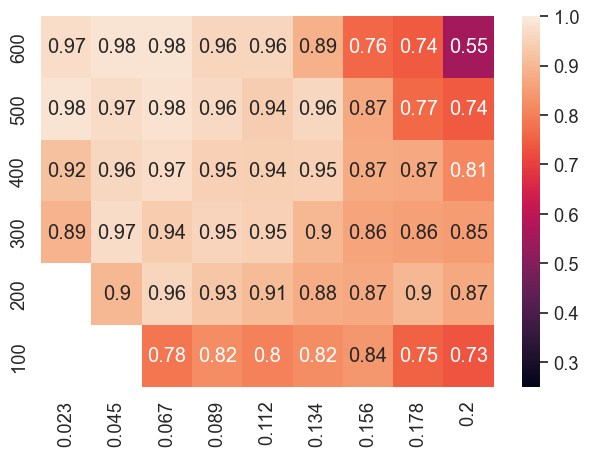

In [13]:
sns.heatmap(
    netana.get_overall_scores(
        get_score="Micro-F1", # --> computed with netana.classify()
        common_p=True
    ),
    vmin = 0.25, vmax=1,
    annot=True
)

plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

## 🎨 Visualisation <a class="anchor" id="visualise"></a>

To get a better intuition on how the representation spaces are orgnised, the distribution of the different families are represented in 2 dimensions. The representations are mapped to 2 dimensions using t-SNE and the distribution are estimated through Kernel Density Estimation (KDE).

The code below produces one plot per $(n,m)$ pair in the synthetic dataset. The number of nodes are the rows of the figure and the number of edges its columns.

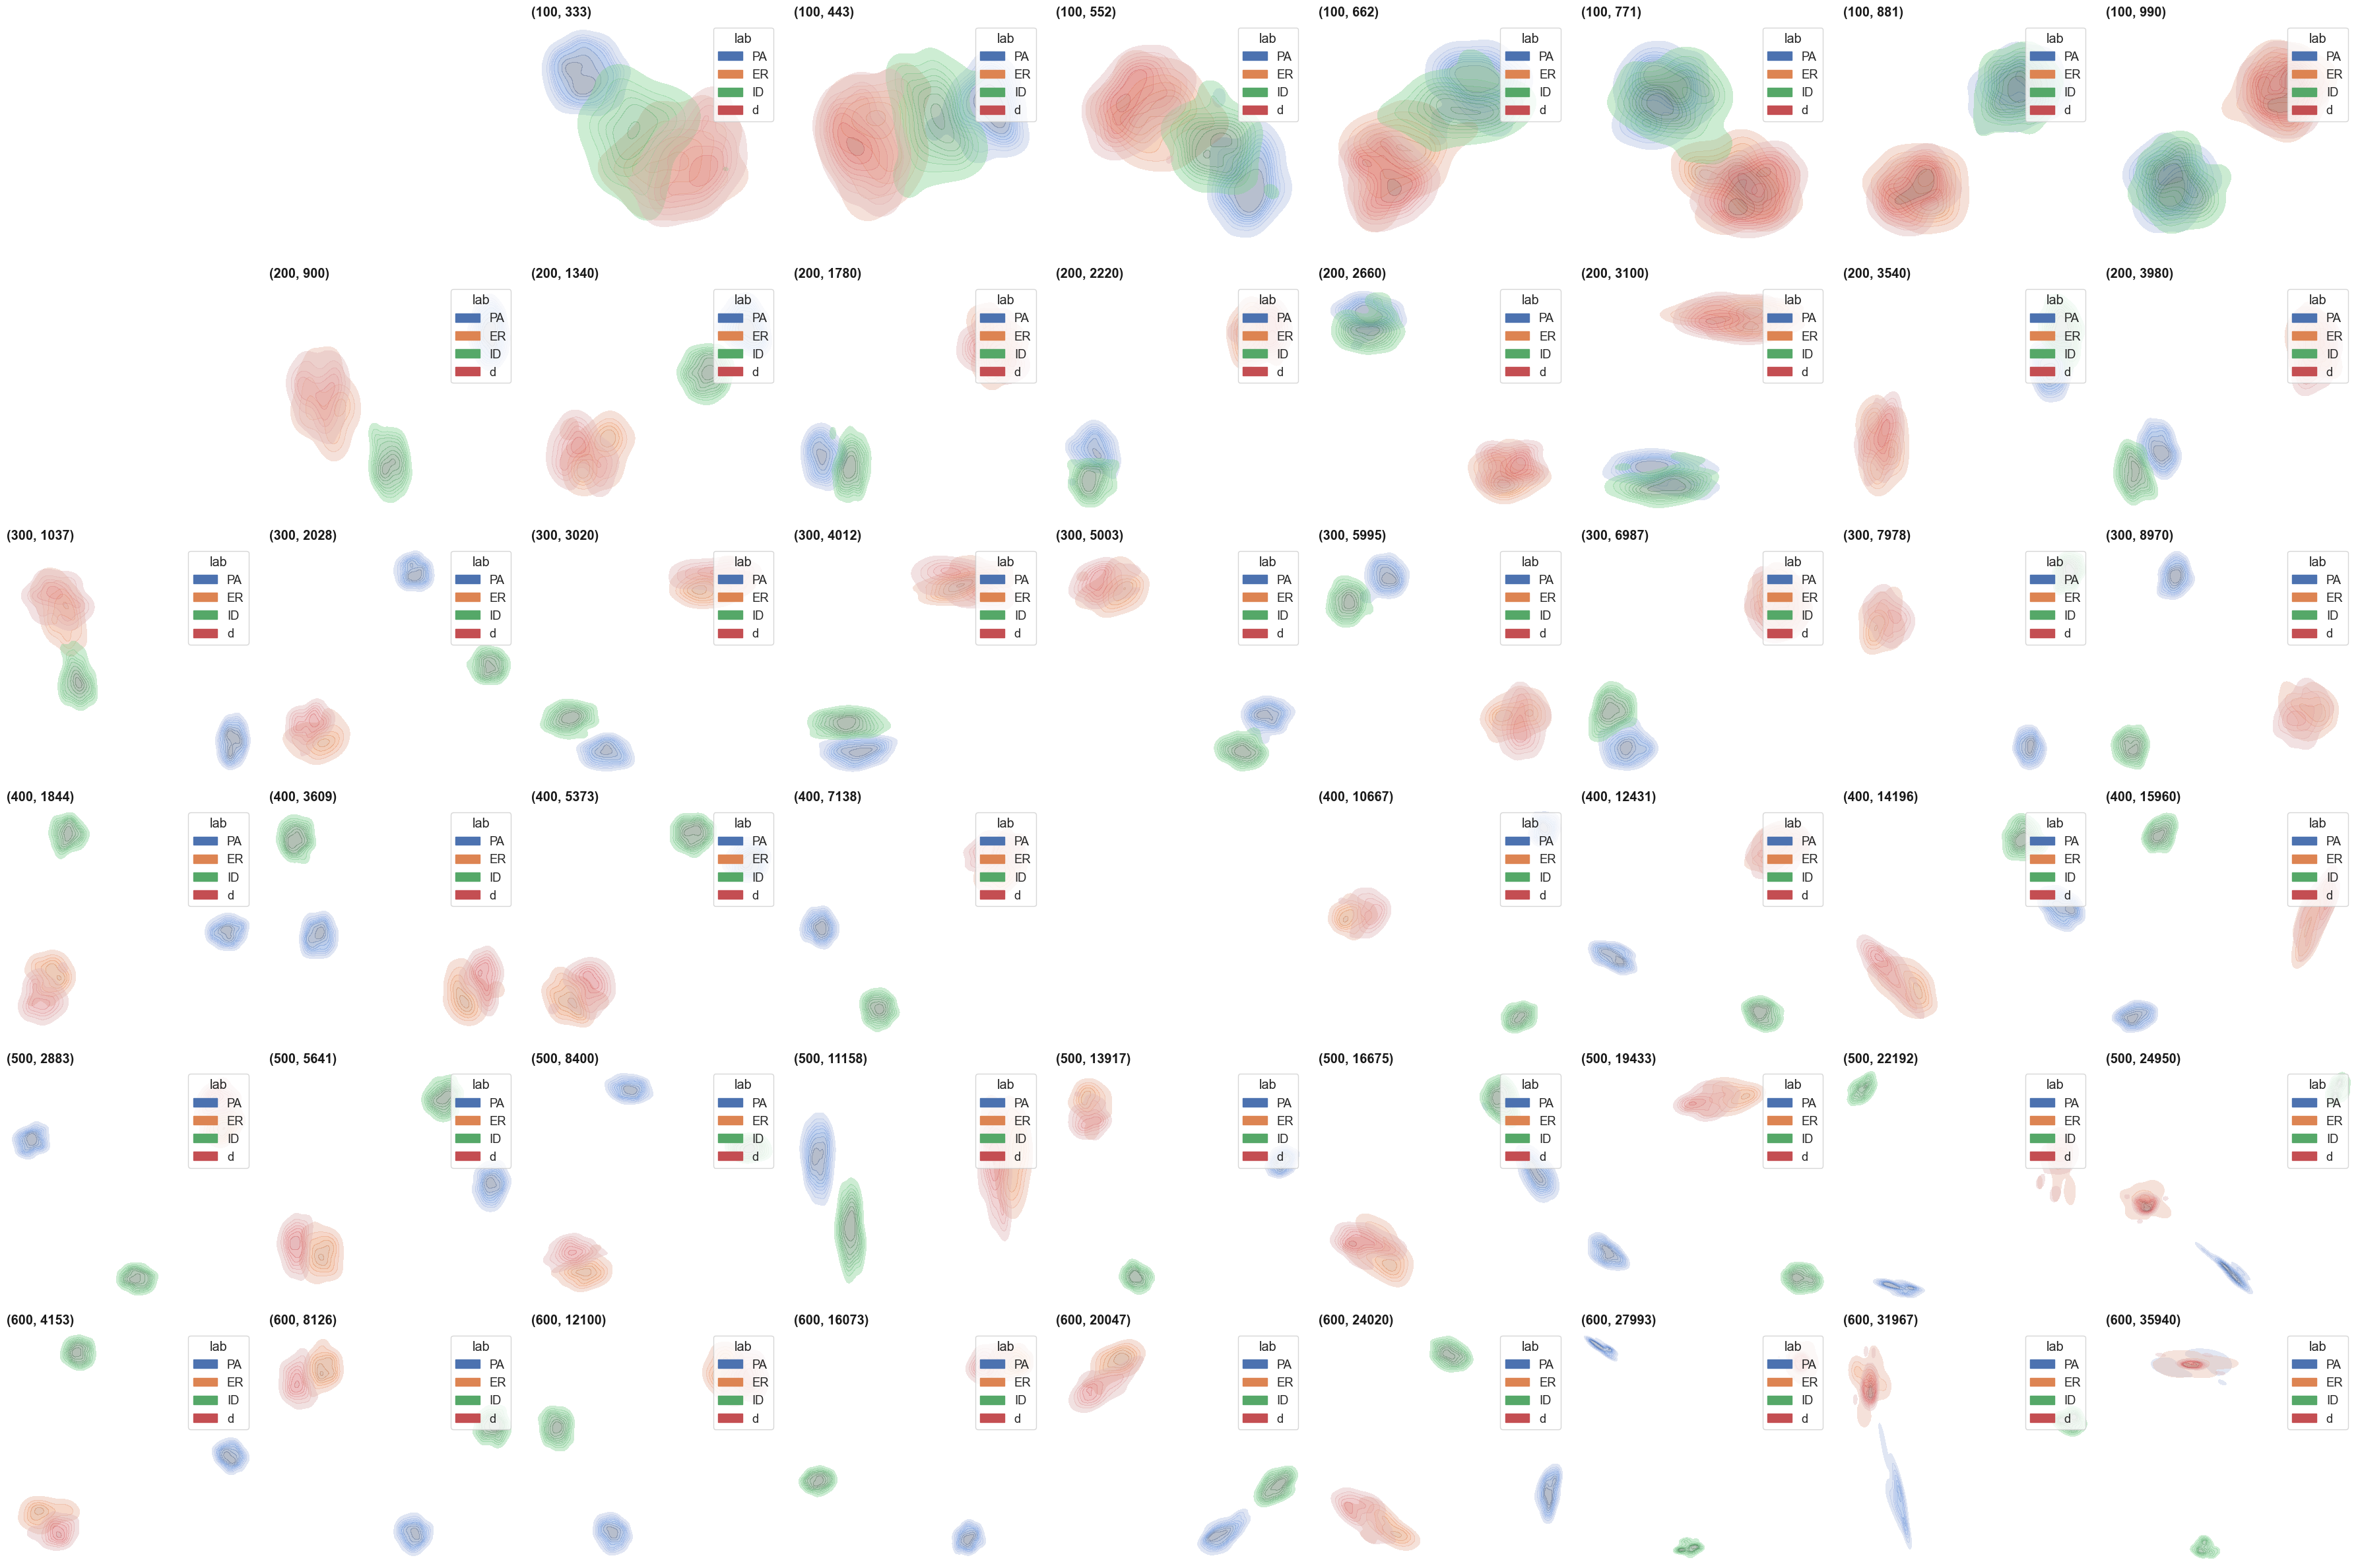

In [25]:
%%capture --no-display

netana.visualise(
    visualise_ve=visualise_kde
    , reducer=TSNE()
)

## 🔎 Space Segregation Analysis <a class="anchor" id="space_seg"></a>

Finally, the main objective of this pipeline is to study the geometric organisation of the induced space. To do so, we employ the silhouette score to measure the ability of the model to segregate semantically different networks within distinct regions of the space. The $SC$ score is computed as an aggregate measure for each $(n,m)$ pair, but it is also computed pairwise by taking into consideration each family pair of the synthetic dataset.

In [15]:
netana.compute_scores()

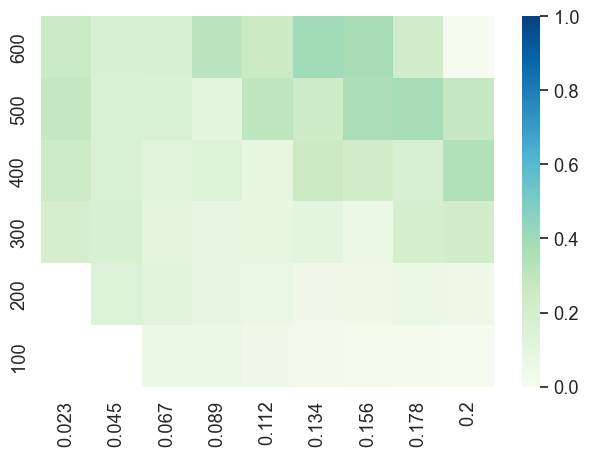

In [16]:
netana.plot_overall_scores()

plt.tight_layout()
#plt.savefig("illustrations/space_seg/ov_silhouette_degs.png")

In [17]:
fam2color_dict = {
    "PA": 'blue',
    "ER": 'orange',
    "ID": 'green',
    "d": 'purple',
}

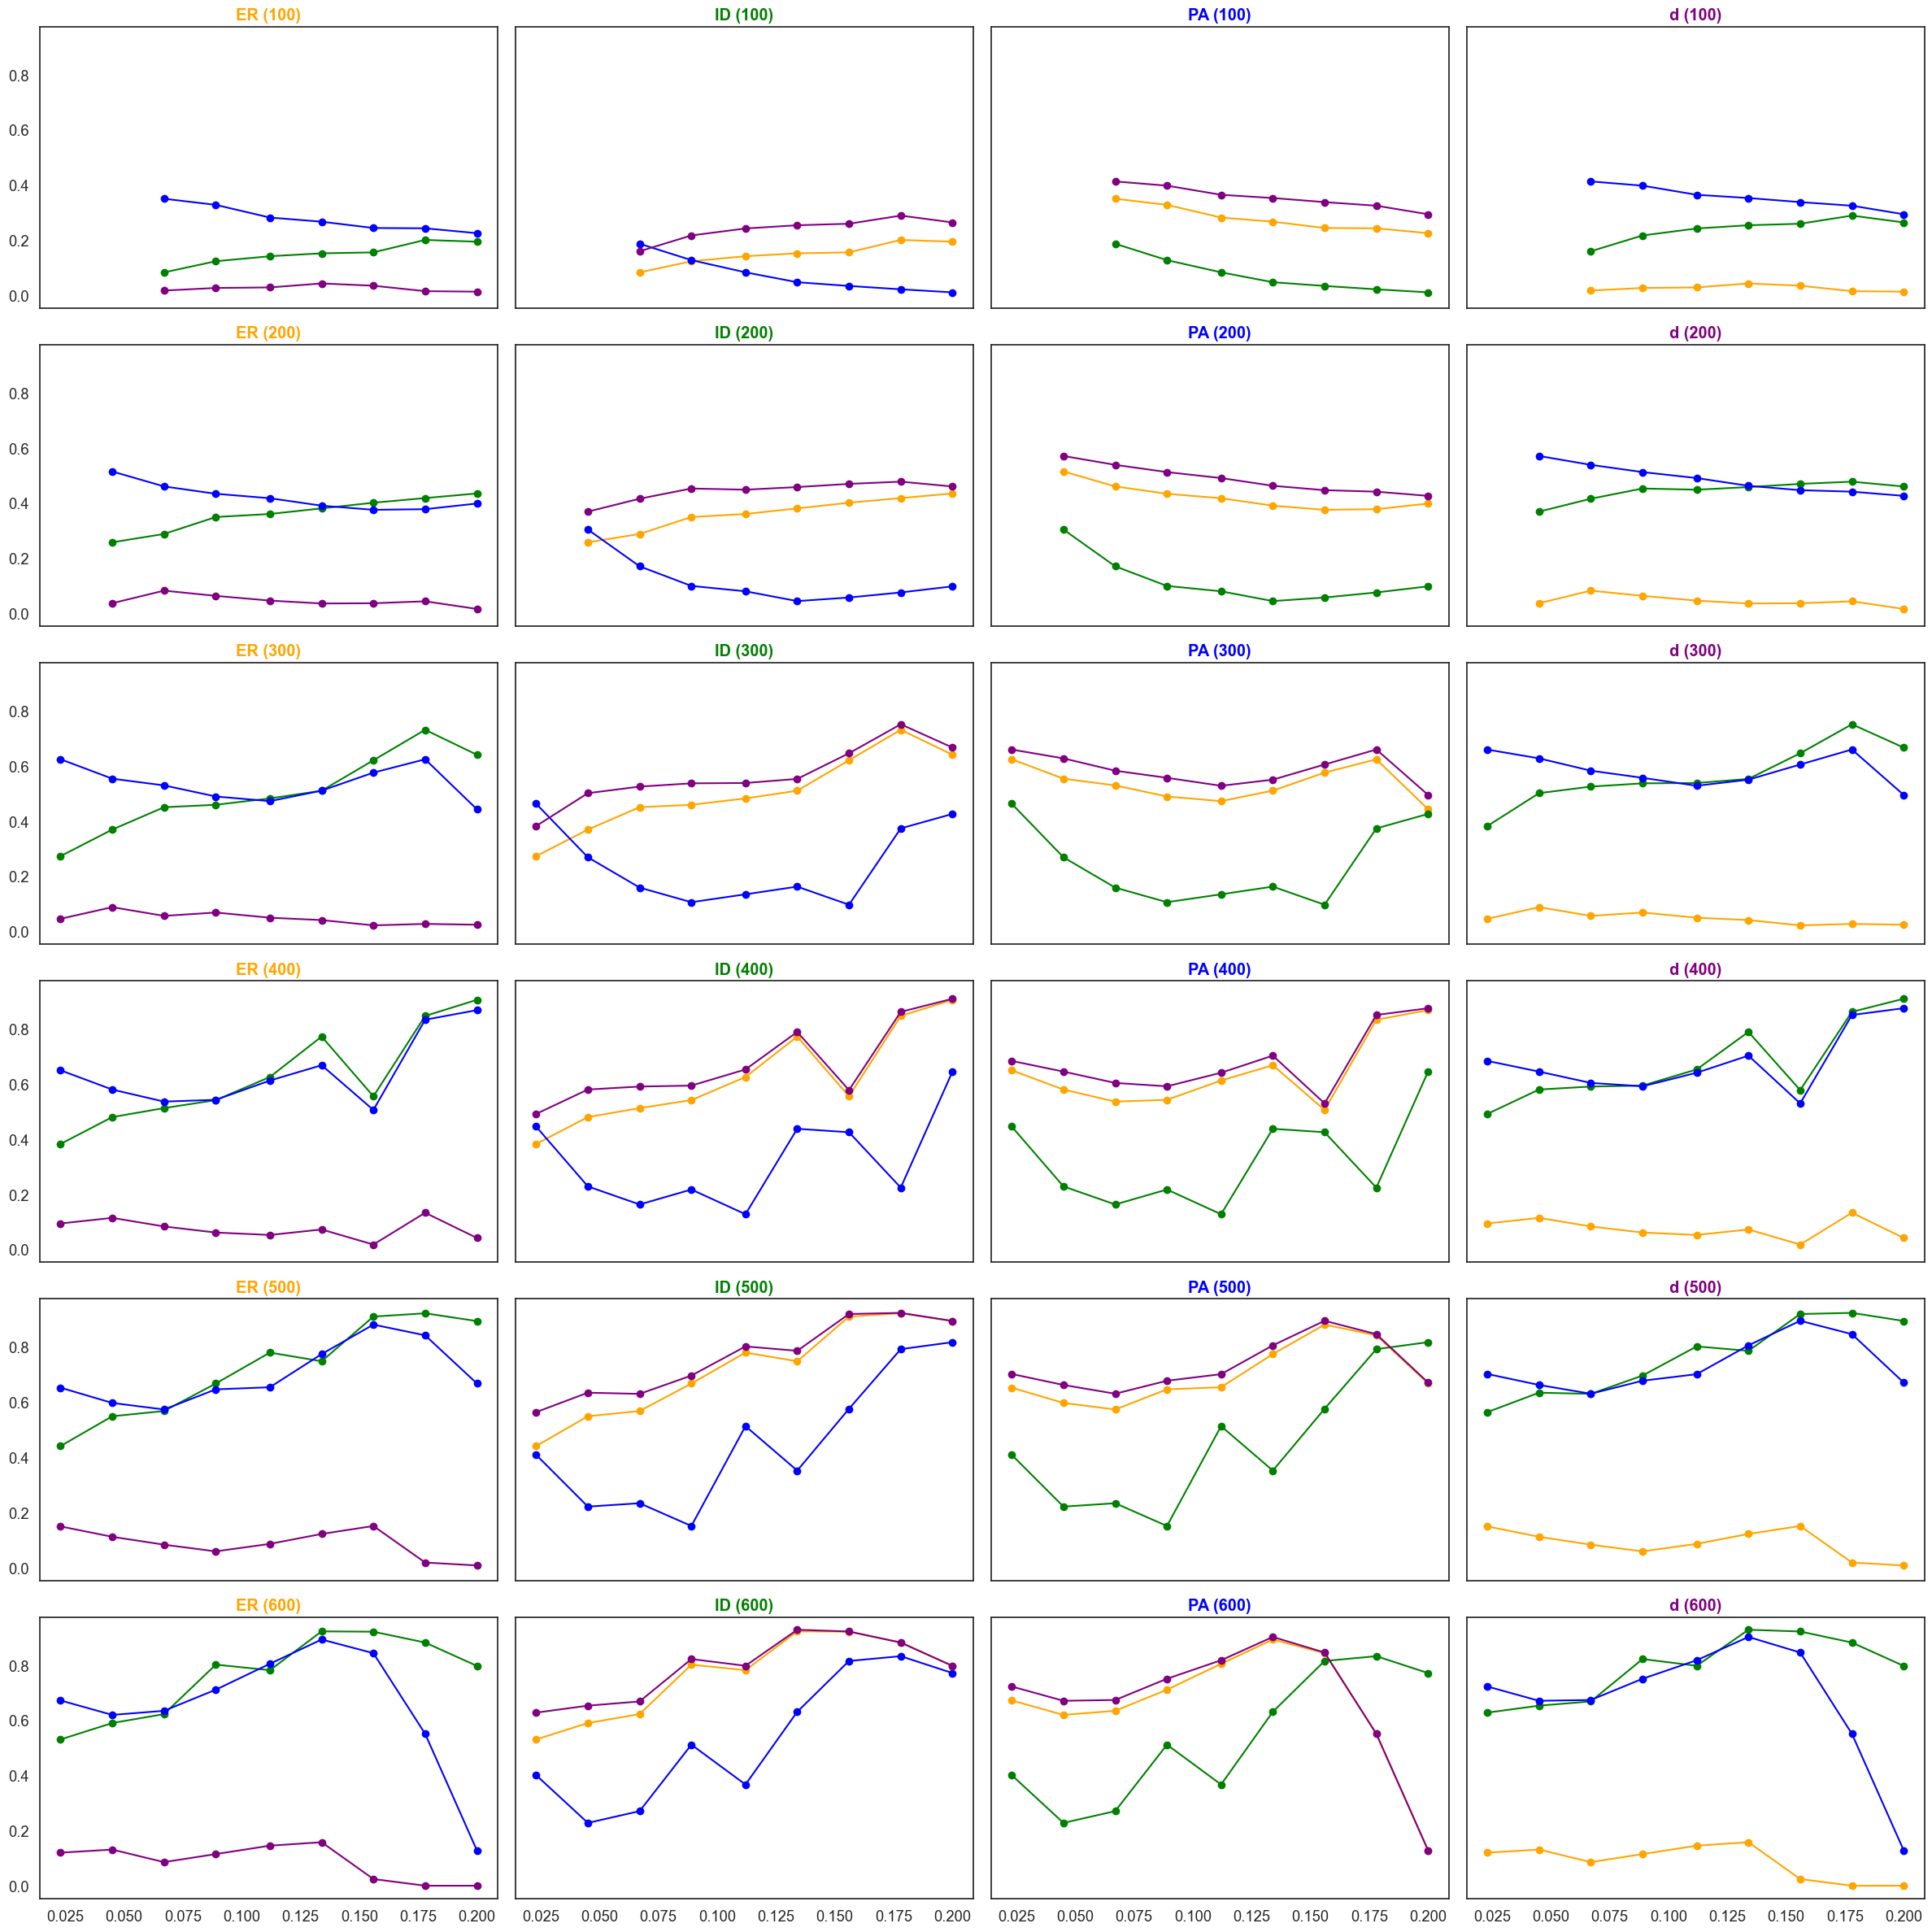

In [18]:
netana.plot_families_scores(
    fam_to_color_dict=fam2color_dict
)

plt.tight_layout()
plt.show()